In [68]:
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine, text, MetaData
from sqlalchemy.exc import IntegrityError
import numpy as np

In [69]:
engine = create_engine('postgres:///piwheels')
conn = engine.connect()
meta = MetaData()
meta.bind = conn
meta.reflect(views=True)

/home/ben/.environments/stats/lib/python3.8/site-packages/sqlalchemy/dialects/postgresql/base.py:3470: SAWarning: Predicate of partial index files_size ignored during reflection
  util.warn(


In [70]:
start_date = '2020-07-01'
end_date = '2020-09-30'
one_year_ago = '2019-10-01'

In [71]:
pd.read_sql(f"""
    SELECT COUNT(*) AS downloads_in_period
    FROM downloads
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
""", conn)

,downloads_in_period
0,4492796


In [6]:
pd.read_sql(f"""
    SELECT COUNT(*) AS downloads_to_date
    FROM downloads
    WHERE accessed_at::date < '{end_date}'
""", conn)

,downloads_to_date
0,26171957


In [23]:
pd.read_sql(f"""
    SELECT COUNT(*) AS project_page_hits
    FROM project_page_hits
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
""", conn)

,project_page_hits
0,597675


In [24]:
pd.read_sql(f"""
    SELECT COUNT(*) AS web_page_hits
    FROM web_page_hits
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
""", conn)

,web_page_hits
0,332517


In [7]:
downloads_by_month = pd.read_sql(f"""
    SELECT date_trunc('month', accessed_at) m, COUNT(*) AS c
    FROM downloads
    WHERE accessed_at::date BETWEEN '{one_year_ago}' AND '{end_date}'
    GROUP BY m
    ORDER BY m
""", conn)

downloads_by_month

,m,c
0,2019-10-01,920963
1,2019-11-01,1014683
2,2019-12-01,1032964
3,2020-01-01,1079669
4,2020-02-01,985288
5,2020-03-01,1300742
6,2020-04-01,1199122
7,2020-05-01,1271968
8,2020-06-01,1127875
9,2020-07-01,1102139


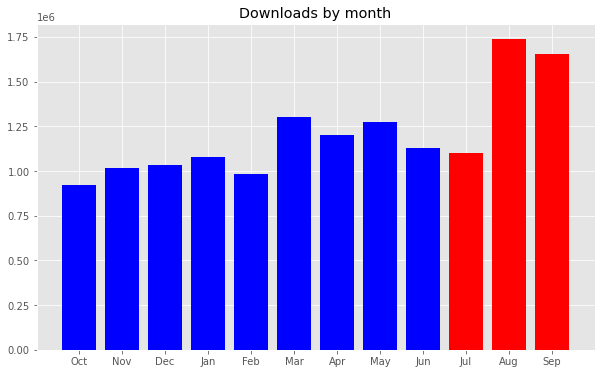

In [8]:
plt.rcParams["figure.figsize"] = (10, 6)

downloads = {
    'Oct': downloads_by_month.c[0],
    'Nov': downloads_by_month.c[1],
    'Dec': downloads_by_month.c[2],
    'Jan': downloads_by_month.c[3],
    'Feb': downloads_by_month.c[4],
    'Mar': downloads_by_month.c[5],
    'Apr': downloads_by_month.c[6],
    'May': downloads_by_month.c[7],
    'Jun': downloads_by_month.c[8],
    'Jul': downloads_by_month.c[9],
    'Aug': downloads_by_month.c[10],
    'Sep': downloads_by_month.c[11],
}

colors = ['blue']*9 + ['red']*3
plt.bar(range(len(downloads)), downloads.values(), color=colors)
plt.title('Downloads by month')
plt.xticks(range(len(downloads)), list(downloads.keys()))

plt.savefig('downloads-by-month.png')

plt.show()

In [10]:
downloads_by_day = pd.read_sql(f"""
    SELECT accessed_at::date AS d, COUNT(*) AS downloads
    FROM downloads
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY d
    ORDER BY d
""", conn)

downloads_by_day

,d,downloads
0,2020-07-01,39625
1,2020-07-02,37730
2,2020-07-03,35179
3,2020-07-04,31345
4,2020-07-05,45192
...,...,...
87,2020-09-26,49693
88,2020-09-27,50060
89,2020-09-28,51771
90,2020-09-29,51027


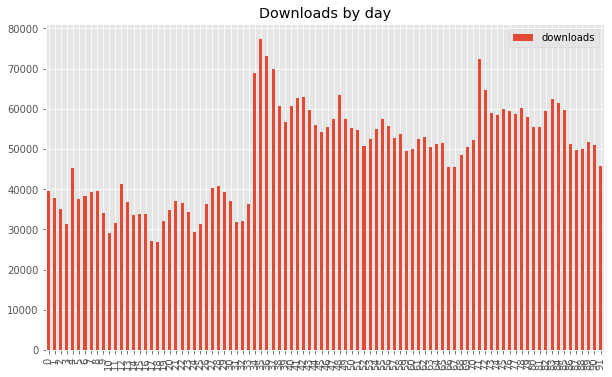

In [11]:
p = downloads_by_day.plot.bar(title='Downloads by day')
p.figure.savefig('downloads-by-day.png')

In [77]:
df = pd.read_sql(f"""
    SELECT COUNT(*) AS searches_in_period
    FROM searches
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
""", conn)

searches = df.values[0][0]

In [19]:
pd.read_sql(f"""
    SELECT date_trunc('month', accessed_at) AS month, COUNT(*) AS searches
    FROM searches
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY month
    ORDER BY month
""", conn)

,month,searches
0,2020-07-01,11473197
1,2020-08-01,15040323
2,2020-09-01,13922071


In [21]:
searches_by_day = pd.read_sql(f"""
    SELECT accessed_at::date AS day, COUNT(*) AS searches
    FROM searches
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY day
    ORDER BY day
""", conn)

searches_by_day

,day,searches
0,2020-07-01,422816
1,2020-07-02,387272
2,2020-07-03,351793
3,2020-07-04,335393
4,2020-07-05,430520
...,...,...
87,2020-09-26,408464
88,2020-09-27,411345
89,2020-09-28,448726
90,2020-09-29,453911


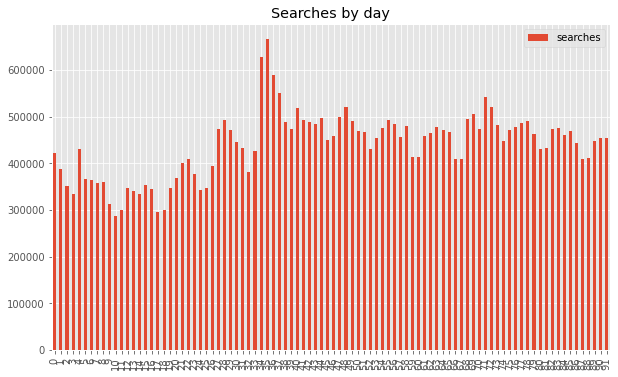

In [22]:
p = searches_by_day.plot.bar(title='Searches by day')
p.figure.savefig('searches-by-day.png')

In [26]:
pd.read_sql(f"""
    SELECT JUSTIFY_INTERVAL(SUM(
        CASE f.platform_tag
            WHEN 'linux_armv7l' THEN 1                           
            WHEN 'linux_armv6l' THEN 6                                                       
            ELSE 0           
        END *
        CASE                        
            WHEN b.duration > INTERVAL '1 week' THEN INTERVAL '0'
            WHEN b.duration > INTERVAL '6.7 seconds' THEN b.duration - INTERVAL '6.7 seconds'
            ELSE INTERVAL '0'               
        END                  
        )) AS total_time_saved_in_quarter                        
    FROM downloads d
    JOIN files f ON d.filename = f.filename
    JOIN builds b ON b.build_id = f.build_id
    WHERE f.abi_tag <> 'none'
    AND d.accessed_at::date between '{start_date}' and '{end_date}'
""", conn)

,total_time_saved_in_quarter
0,29458 days 17:51:55.365536


In [30]:
pd.read_sql(f"""
    SELECT date_trunc('month', d.accessed_at) as month, JUSTIFY_INTERVAL(SUM(
        CASE f.platform_tag
            WHEN 'linux_armv7l' THEN 1
            WHEN 'linux_armv6l' THEN 6
            ELSE 0
        END *
        CASE
            WHEN b.duration > INTERVAL '1 week' THEN INTERVAL '0'
            WHEN b.duration > INTERVAL '6.7 seconds' THEN b.duration - INTERVAL '6.7 seconds'
            ELSE INTERVAL '0'
        END
            )) AS time_saved_in_month
    FROM downloads d
    JOIN files f ON d.filename = f.filename
    JOIN builds b ON b.build_id = f.build_id
    WHERE f.abi_tag <> 'none'
    AND d.accessed_at::date between '{one_year_ago}' and '{end_date}'
    GROUP BY month
    ORDER BY month
""", conn)

,month,time_saved_in_month
0,2019-10-01,5043 days 19:37:03.022912
1,2019-11-01,6492 days 09:32:37.692694
2,2019-12-01,6613 days 23:37:23.203709
3,2020-01-01,6498 days 01:18:11.967479
4,2020-02-01,7218 days 00:56:35.774120
5,2020-03-01,8467 days 12:38:01.956040
6,2020-04-01,7738 days 10:24:55.584583
7,2020-05-01,9265 days 22:25:14.640144
8,2020-06-01,8727 days 01:46:24.947397
9,2020-07-01,8705 days 13:02:56.146469


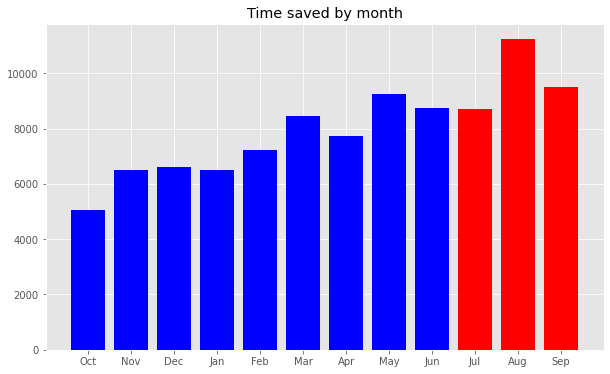

In [31]:
time_saved = {
    'Oct': 5043,
    'Nov': 6492,
    'Dec': 6613,
    'Jan': 6498,
    'Feb': 7218,
    'Mar': 8467,
    'Apr': 7738,
    'May': 9265,
    'Jun': 8727,
    'Jul': 8705,
    'Aug': 11233,
    'Sep': 9514,
}

colors = ['blue']*9 + ['red']*3
plt.bar(range(len(time_saved)), time_saved.values(), color=colors)
plt.title('Time saved by month')
plt.xticks(range(len(time_saved)), list(time_saved.keys()))

plt.savefig('time-saved-by-month.png')

plt.show()

In [114]:
pd.read_sql(f"""
    SELECT JUSTIFY_INTERVAL(SUM(
        CASE f.platform_tag
            WHEN 'linux_armv7l' THEN 1
            WHEN 'linux_armv6l' THEN 6
            ELSE 0
        END *
        CASE
            WHEN b.duration > INTERVAL '1 week' THEN INTERVAL '0'
            WHEN b.duration > INTERVAL '6.7 seconds' THEN b.duration - INTERVAL '6.7 seconds'
            ELSE INTERVAL '0'
        END
            )) AS time_saved_total
    FROM downloads d
    JOIN files f ON d.filename = f.filename
    JOIN builds b ON b.build_id = f.build_id
    WHERE f.abi_tag <> 'none'
""", conn)

OverflowError: Python int too large to convert to C long

In [43]:
top_10_downloads = pd.read_sql(f"""
    select b.package, count(*) c
    from downloads d
    join files f on f.filename = d.filename
    join builds b on b.build_id = f.build_id
    where accessed_at::date between '{start_date}' and '{end_date}'
    group by b.package
    order by c desc
    limit 10;
""", conn)

top_10_downloads

,package,c
0,numpy,551732
1,dogpile-cache,388880
2,sentry-sdk,125560
3,requests,106192
4,octoprint-firmwarecheck,102182
5,filetype,101755
6,semantic-version,94750
7,pyyaml,92459
8,cython,74871
9,markdown,67303


In [44]:
print("<ol>")
for i, row in top_10_downloads.iterrows():
    print(f"<li><strong><a href='https://www.piwheels.org/project/{row['package']}'>{row['package']}</a></strong> ({row['c']:,})</li>")
print("</ol>")

<ol>
<li><strong><a href='https://www.piwheels.org/project/numpy'>numpy</a></strong> (551,732)</li>
<li><strong><a href='https://www.piwheels.org/project/dogpile-cache'>dogpile-cache</a></strong> (388,880)</li>
<li><strong><a href='https://www.piwheels.org/project/sentry-sdk'>sentry-sdk</a></strong> (125,560)</li>
<li><strong><a href='https://www.piwheels.org/project/requests'>requests</a></strong> (106,192)</li>
<li><strong><a href='https://www.piwheels.org/project/octoprint-firmwarecheck'>octoprint-firmwarecheck</a></strong> (102,182)</li>
<li><strong><a href='https://www.piwheels.org/project/filetype'>filetype</a></strong> (101,755)</li>
<li><strong><a href='https://www.piwheels.org/project/semantic-version'>semantic-version</a></strong> (94,750)</li>
<li><strong><a href='https://www.piwheels.org/project/pyyaml'>pyyaml</a></strong> (92,459)</li>
<li><strong><a href='https://www.piwheels.org/project/cython'>cython</a></strong> (74,871)</li>
<li><strong><a href='https://www.piwheels.o

In [46]:
top_10_searches = pd.read_sql(f"""
    select package, count(*) c
    from searches
    where accessed_at::date between '{start_date}' and '{end_date}'
    group by package
    order by c desc
    limit 10;
""", conn)

In [48]:
top_10_searches = {
    'pip':        5540997,
    'wheel':      3418343,
    'setuptools': 1900293,
    'numpy':       899174,
    'pyrogram':    700198,
    'youtube-dl':  610228,
    'requests':    585098,
    'certifi':     430260,
    'six':         408890,
    'urllib3':     400772,
}

In [49]:
print("<ol>")
for pkg, c in top_10_searches.items():
    print(f"<li><strong><a href='https://www.piwheels.org/project/{pkg}'>{pkg}</a></strong> ({c:,})</li>")
print("</ol>")

<ol>
<li><strong><a href='https://www.piwheels.org/project/pip'>pip</a></strong> (5,540,997)</li>
<li><strong><a href='https://www.piwheels.org/project/wheel'>wheel</a></strong> (3,418,343)</li>
<li><strong><a href='https://www.piwheels.org/project/setuptools'>setuptools</a></strong> (1,900,293)</li>
<li><strong><a href='https://www.piwheels.org/project/numpy'>numpy</a></strong> (899,174)</li>
<li><strong><a href='https://www.piwheels.org/project/pyrogram'>pyrogram</a></strong> (700,198)</li>
<li><strong><a href='https://www.piwheels.org/project/youtube-dl'>youtube-dl</a></strong> (610,228)</li>
<li><strong><a href='https://www.piwheels.org/project/requests'>requests</a></strong> (585,098)</li>
<li><strong><a href='https://www.piwheels.org/project/certifi'>certifi</a></strong> (430,260)</li>
<li><strong><a href='https://www.piwheels.org/project/six'>six</a></strong> (408,890)</li>
<li><strong><a href='https://www.piwheels.org/project/urllib3'>urllib3</a></strong> (400,772)</li>
</ol>


In [44]:
print("<ol>")
for i, row in top_10_searches.iterrows():
    print(f"<li><strong><a href='https://www.piwheels.org/project/{row['package']}'>{row['package']}</a></strong> ({row['c']:,})</li>")
print("</ol>")

<ol>
<li><strong><a href='https://www.piwheels.org/project/numpy'>numpy</a></strong> (551,732)</li>
<li><strong><a href='https://www.piwheels.org/project/dogpile-cache'>dogpile-cache</a></strong> (388,880)</li>
<li><strong><a href='https://www.piwheels.org/project/sentry-sdk'>sentry-sdk</a></strong> (125,560)</li>
<li><strong><a href='https://www.piwheels.org/project/requests'>requests</a></strong> (106,192)</li>
<li><strong><a href='https://www.piwheels.org/project/octoprint-firmwarecheck'>octoprint-firmwarecheck</a></strong> (102,182)</li>
<li><strong><a href='https://www.piwheels.org/project/filetype'>filetype</a></strong> (101,755)</li>
<li><strong><a href='https://www.piwheels.org/project/semantic-version'>semantic-version</a></strong> (94,750)</li>
<li><strong><a href='https://www.piwheels.org/project/pyyaml'>pyyaml</a></strong> (92,459)</li>
<li><strong><a href='https://www.piwheels.org/project/cython'>cython</a></strong> (74,871)</li>
<li><strong><a href='https://www.piwheels.o

In [117]:
top_10_project_pages = pd.read_sql(f"""
    select package, count(*) c
    from project_page_hits
    where accessed_at::date between '{start_date}' and '{end_date}'
    group by package
    order by c desc
    limit 10;
""", conn)

top_10_project_pages

,package,c
0,opencv-python,2524
1,opencv-contrib-python,1259
2,numpy,1217
3,scipy,1080
4,tensorflow,1004
5,pip,645
6,opencv-python-headless,430
7,pillow,429
8,grpcio,412
9,pandas,318


In [118]:
print("<ol>")
for i, row in top_10_project_pages.iterrows():
    print(f"<li><strong><a href='https://www.piwheels.org/project/{row['package']}'>{row['package']}</a></strong> ({row['c']:,})</li>")
print("</ol>")

<ol>
<li><strong><a href='https://www.piwheels.org/project/opencv-python'>opencv-python</a></strong> (2,524)</li>
<li><strong><a href='https://www.piwheels.org/project/opencv-contrib-python'>opencv-contrib-python</a></strong> (1,259)</li>
<li><strong><a href='https://www.piwheels.org/project/numpy'>numpy</a></strong> (1,217)</li>
<li><strong><a href='https://www.piwheels.org/project/scipy'>scipy</a></strong> (1,080)</li>
<li><strong><a href='https://www.piwheels.org/project/tensorflow'>tensorflow</a></strong> (1,004)</li>
<li><strong><a href='https://www.piwheels.org/project/pip'>pip</a></strong> (645)</li>
<li><strong><a href='https://www.piwheels.org/project/opencv-python-headless'>opencv-python-headless</a></strong> (430)</li>
<li><strong><a href='https://www.piwheels.org/project/pillow'>pillow</a></strong> (429)</li>
<li><strong><a href='https://www.piwheels.org/project/grpcio'>grpcio</a></strong> (412)</li>
<li><strong><a href='https://www.piwheels.org/project/pandas'>pandas</a></

In [122]:
top_10_project_json = pd.read_sql(f"""
    select package, count(*) c
    from project_json_downloads
    where accessed_at::date between '{start_date}' and '{end_date}'
    group by package
    order by c desc
    limit 10;
""", conn)

top_10_project_json

,package,c
0,numpy,45
1,scipy,36
2,opencv-python,8
3,opencv-python-headless,5
4,opencv-contrib-python,2
5,ighack,2
6,genox,2
7,azureml-contrib-functions,2
8,av,2
9,gpiozero,2


In [52]:
os_usage = pd.read_sql(f"""
    select os_name, count(*) c
    from searches
    where accessed_at::date between '{start_date}' and '{end_date}'
    group by os_name
    order by c desc
""", conn)

os_usage

,os_name,c
0,Linux,40398043
1,Windows,24582
2,Darwin,12835
3,None,110
4,Ibnu Rifqi,21


In [78]:
os_usage.values[0][1] / searches

0.9990714121131554

In [63]:
distro_usage = pd.read_sql(f"""
    select distro_name, count(*) c
    from searches
    where accessed_at::date between '{start_date}' and '{end_date}'
    and os_name = 'Linux'
    group by distro_name
    order by c desc
    limit 5
""", conn)

distro_usage

,distro_name,c
0,Raspbian GNU/Linux,38030119
1,Debian GNU/Linux,1973278
2,Ubuntu,222747
3,Red Hat Enterprise Linux Server,58199
4,Arch Linux,56115


In [79]:
debian_usage = pd.read_sql(f"""
    select count(*) c
    from searches
    where accessed_at::date between '{start_date}' and '{end_date}'
    and os_name = 'Linux'
    and distro_name in ('Raspbian GNU/Linux', 'Debian GNU/Linux')
    order by c desc
    limit 5
""", conn)

debian_usage

,c
0,40003397


In [80]:
ubuntu_usage = pd.read_sql(f"""
    select count(*) c
    from searches
    where accessed_at::date between '{start_date}' and '{end_date}'
    and os_name = 'Linux'
    and distro_name = 'Ubuntu'
    order by c desc
    limit 5
""", conn)

ubuntu_usage

,c
0,222747


In [86]:
debian = debian_usage.values[0][0]
others = searches - debian

distro_usage = {
    'Debian / Raspbian / PiOS': debian,
    'Others': others,
}

distro_usage

{'Debian / Raspbian / PiOS': 40003397, 'Others': 432194}

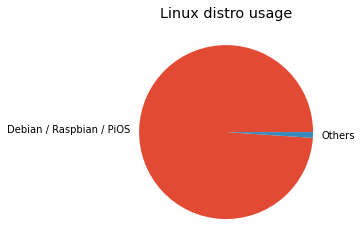

In [87]:
plt.pie(distro_usage.values(), labels=distro_usage.keys())
plt.title('Linux distro usage')

plt.savefig('distro-usage.png')

plt.show()

In [88]:
distro_versions = pd.read_sql(f"""
    select distro_version, count(*) c
    from searches
    where accessed_at::date between '{start_date}' and '{end_date}'
    and os_name = 'Linux'
    and distro_name in ('Raspbian GNU/Linux', 'Debian GNU/Linux')
    and distro_version in ('8', '9', '10')
    group by distro_version
    order by c desc
""", conn)

distro_versions

,distro_version,c
0,10,31467007
1,9,8466021
2,8,3057


In [98]:
total = sum(distro_versions.c)

for v in distro_versions.values:
    print(v[0], f'{(100 * v[1] / total):.1f}%')

10 78.8%
9 21.2%
8 0.0%


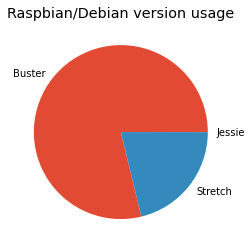

In [90]:
version_names = {'10': 'Buster', '9': 'Stretch', '8': 'Jessie'}
plt.pie(distro_versions.c, labels=[version_names[v] for v in distro_versions.distro_version])
plt.title('Raspbian/Debian version usage')

plt.savefig('debian-usage.png')

plt.show()

In [102]:
arch = pd.read_sql(f"""
    select arch, count(*) c
    from searches
    where accessed_at::date between '{start_date}' and '{end_date}'
    group by arch
    order by c desc
""", conn)

arch

,arch,c
0,armv7l,36888476
1,armv6l,1934747
2,aarch64,764813
3,x86_64,746010
4,i686,53381
5,AMD64,24579
6,armv8l,23470
7,None,110
8,x86,3
9,ppc,2


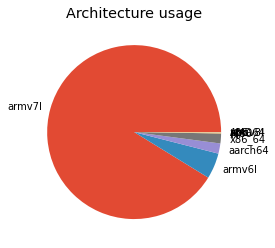

In [100]:
plt.pie(arch.c, labels=arch.arch)
plt.title('Architecture usage')

plt.savefig('arch.png')

plt.show()

In [113]:
arm_arch = pd.read_sql(f"""
    select arch, count(*) c
    from searches
    where accessed_at::date between '{start_date}' and '{end_date}'
    and os_name = 'Linux'
    and distro_name in ('Raspbian GNU/Linux', 'Debian GNU/Linux')
    and arch in ('armv6l', 'armv7l', 'aarch64')
    group by arch
    order by c desc
""", conn)

total = sum(arm_arch.c)

for v in arm_arch.values:
    print(v[0], f'{(100 * v[1] / total):.1f}%') 

armv7l 93.3%
armv6l 4.9%
aarch64 1.8%


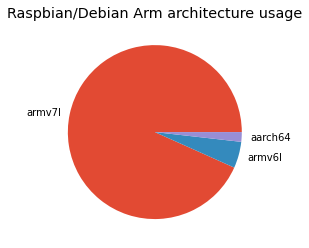

In [104]:
plt.pie(arm_arch.c, labels=arm_arch.arch)
plt.title('Raspbian/Debian Arm architecture usage')

plt.savefig('debian-arch.png')

plt.show()

In [105]:
py_vers = pd.read_sql(f"""
    select substring(py_version from 1 for 3) pyver, count(*) c
    from searches
    where accessed_at::date between '{start_date}' and '{end_date}'
    and py_name = 'CPython'
    group by pyver
    order by c desc
    limit 5
""", conn)

py_vers

,pyver,c
0,3.7,24021823
1,2.7,10863588
2,3.5,3449617
3,3.8,1605475
4,3.6,480179


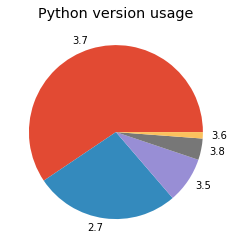

In [106]:
plt.pie(py_vers.c, labels=py_vers.pyver)
plt.title('Python version usage')

plt.savefig('py-vers.png')

plt.show()

In [109]:
pip_versions = pd.read_sql(f"""
    select installer_version, count(*) c
    from searches
    where accessed_at::date between '{start_date}' and '{end_date}'
    and installer_name = 'pip'
    and installer_version is not null
    group by installer_version
    order by c desc
""", conn)

pip_versions[:10]

,installer_version,c
0,18.1,11365236
1,20.2.2,5806465
2,20.1.1,5019396
3,20.2.3,4131963
4,19.3.1,3411900
5,9.0.1,2943069
6,20.2,2385413
7,20.2.1,1508477
8,19.2.3,1059250
9,20.0.2,720176


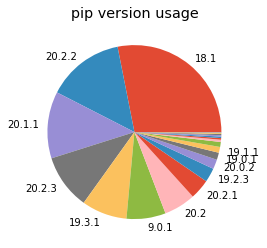

In [145]:
total = sum(v[1] for v in pip_versions.values)
labels = [v[0] if v[1] / total > 0.01 else '' for v in pip_versions.values]

plt.pie(pip_versions.c, labels=labels)
plt.title('pip version usage')

plt.savefig('pip-vers.png')

plt.show()

In [111]:
setuptools_versions = pd.read_sql(f"""
    select setuptools_version, count(*) c
    from searches
    where accessed_at::date between '{start_date}' and '{end_date}'
    and installer_name = 'pip'
    and setuptools_version is not null
    group by setuptools_version
    order by c desc
""", conn)

setuptools_versions[:10]

,setuptools_version,c
0,40.8.0,18857712
1,41.5.1,3159608
2,50.3.0,1712218
3,41.2.0,1611254
4,49.2.0,1419185
5,44.1.1,1363174
6,49.6.0,1282906
7,44.0.0,1218595
8,40.7.1,550424
9,46.1.3,540116


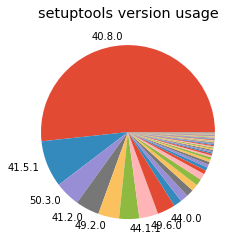

In [142]:
total = sum(v[1] for v in setuptools_versions.values)
labels = [v[0] if v[1] / total > 0.03 else '' for v in setuptools_versions.values]

plt.pie(setuptools_versions.c, labels=labels)
plt.title('setuptools version usage')

plt.savefig('setuptools-vers.png')

plt.show()